# Optiver Trading at the Close - Продвинутая разработка признаков

Этот ноутбук реализует два новых подхода на основе результатов разведочного анализа данных (EDA):

**Подход 1: Временные лаговые признаки и динамика аукциона**
- Лаговые признаки (значения предыдущих временных интервалов)
- Признаки изменений (дельты)
- Скользящие агрегации
- Признаки временной позиции

**Подход 2: Кросс-секционные рыночные признаки**
- Рыночные агрегаты по time_id
- Относительные признаки (акция vs рынок)
- Кластеризация акций по волатильности


## 1. Настройка и загрузка данных

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import gc

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

PROJECT_ROOT = Path('/root/Optiver')
DATA_DIR = PROJECT_ROOT / 'data'
TRAIN_PATH = DATA_DIR / 'train.csv'

print(f'Файл train существует: {TRAIN_PATH.exists()}')

Файл train существует: True


In [2]:
# Оптимизированные типы данных
dtypes = {
    'stock_id': 'int16',
    'date_id': 'int16',
    'seconds_in_bucket': 'int16',
    'imbalance_size': 'float32',
    'imbalance_buy_sell_flag': 'int8',
    'reference_price': 'float32',
    'matched_size': 'float32',
    'far_price': 'float32',
    'near_price': 'float32',
    'bid_price': 'float32',
    'bid_size': 'float32',
    'ask_price': 'float32',
    'ask_size': 'float32',
    'wap': 'float32',
    'target': 'float32',
    'time_id': 'int32',
    'row_id': 'str'
}

print('Загрузка данных...')
df = pd.read_csv(TRAIN_PATH, dtype=dtypes)
print(f'Размер: {df.shape}')
print(f'Память: {df.memory_usage(deep=True).sum() / 1e6:.1f} МБ')

# Удаляем строки с пропущенным target
df = df.dropna(subset=['target'])
print(f'После удаления NaN в target: {len(df):,}')

Загрузка данных...
Размер: (5237980, 17)
Память: 639.2 МБ
После удаления NaN в target: 5,237,892


In [3]:
# Разделение по времени: последние 20% дат для валидации
n_dates = df['date_id'].nunique()
val_dates = int(n_dates * 0.2)
split_date = df['date_id'].max() - val_dates

print(f'Всего дат: {n_dates}')
print(f'Разделение на date_id: {split_date}')
print(f'Train даты: 0-{split_date}, Val даты: {split_date+1}-{df["date_id"].max()}')

Всего дат: 481
Разделение на date_id: 384
Train даты: 0-384, Val даты: 385-480


## 2. Подход 1: Временные лаговые признаки и динамика аукциона

Ключевое наблюдение: Каждая пара акция-дата содержит последовательность из ~55 наблюдений за 10-минутный аукцион.

In [4]:
def create_temporal_features(df):
    """
    Создание временных/лаговых признаков внутри каждого аукциона акция-дата.
    """
    print('Создание временных признаков...')
    start = time.time()
    
    # Сортировка по stock_id, date_id, seconds_in_bucket для корректного вычисления лагов
    df = df.sort_values(['stock_id', 'date_id', 'seconds_in_bucket']).reset_index(drop=True)
    
    # Группировка по акция-дата для лаговых признаков
    group = df.groupby(['stock_id', 'date_id'])
    
    # === Лаговые признаки ===
    # Лаги размера дисбаланса
    df['imbalance_size_lag1'] = group['imbalance_size'].shift(1)
    df['imbalance_size_lag2'] = group['imbalance_size'].shift(2)
    
    # Лаг matched size
    df['matched_size_lag1'] = group['matched_size'].shift(1)
    
    # Лаги bid/ask size
    df['bid_size_lag1'] = group['bid_size'].shift(1)
    df['ask_size_lag1'] = group['ask_size'].shift(1)
    
    # Лаги WAP и reference price
    df['wap_lag1'] = group['wap'].shift(1)
    df['reference_price_lag1'] = group['reference_price'].shift(1)
    
    # === Признаки изменений (дельты) ===
    df['imbalance_delta'] = df['imbalance_size'] - df['imbalance_size_lag1']
    df['matched_delta'] = df['matched_size'] - df['matched_size_lag1']
    df['matched_growth'] = df['matched_delta'] / (df['matched_size_lag1'] + 1)
    
    df['bid_size_delta'] = df['bid_size'] - df['bid_size_lag1']
    df['ask_size_delta'] = df['ask_size'] - df['ask_size_lag1']
    
    df['wap_delta'] = df['wap'] - df['wap_lag1']
    df['ref_price_delta'] = df['reference_price'] - df['reference_price_lag1']
    
    # Скорость изменения книги заявок
    df['book_imbalance'] = df['bid_size'] - df['ask_size']
    df['book_imbalance_lag1'] = group['book_imbalance'].shift(1)
    df['book_imbalance_delta'] = df['book_imbalance'] - df['book_imbalance_lag1']
    
    # === Скользящие агрегации ===
    # Скользящее среднее дисбаланса (за последние 3 временных интервала)
    df['imbalance_roll_mean3'] = group['imbalance_size'].transform(
        lambda x: x.rolling(3, min_periods=1).mean()
    )
    df['imbalance_roll_std3'] = group['imbalance_size'].transform(
        lambda x: x.rolling(3, min_periods=1).std()
    )
    
    # Кумулятивный максимум matched size (как % от финального)
    df['matched_cummax'] = group['matched_size'].transform('cummax')
    
    # === Признаки временной позиции ===
    df['time_remaining'] = 540 - df['seconds_in_bucket']
    df['auction_progress'] = df['seconds_in_bucket'] / 540.0
    df['is_late_auction'] = (df['seconds_in_bucket'] > 300).astype('int8')
    df['is_early_auction'] = (df['seconds_in_bucket'] <= 120).astype('int8')
    
    # Ранг временного интервала внутри аукциона (0 = первый, 54 = последний)
    df['time_bucket_rank'] = group.cumcount()
    
    print(f'Временные признаки созданы за {time.time()-start:.1f}с')
    return df

# Применяем временные признаки
df = create_temporal_features(df)
print(f'Размер после временных признаков: {df.shape}')

Создание временных признаков...
Временные признаки созданы за 26.5с
Размер после временных признаков: (5237892, 42)


## 3. Подход 2: Кросс-секционные рыночные признаки

Ключевое наблюдение: Общерыночные сигналы могут отражать системные эффекты.

In [5]:
def create_market_features(df):
    """
    Создание кросс-секционных рыночных признаков.
    """
    print('Создание рыночных признаков...')
    start = time.time()
    
    # признак спреда
    df['spread'] = df['ask_price'] - df['bid_price']
    
    # === Рыночные агрегации (по time_id) ===
    market_stats = df.groupby('time_id').agg({
        'imbalance_size': ['mean', 'std'],
        'matched_size': ['mean', 'sum'],
        'spread': 'mean',
        'imbalance_buy_sell_flag': 'mean',  # % покупок vs продаж
        'book_imbalance': ['mean', 'std'],
    }).reset_index()
    
    # Упрощаем названия колонок
    market_stats.columns = [
        'time_id', 
        'mkt_imb_mean', 'mkt_imb_std',
        'mkt_match_mean', 'mkt_match_sum',
        'mkt_spread',
        'mkt_buy_pct',
        'mkt_book_imb_mean', 'mkt_book_imb_std'
    ]
    
    # Объединяем рыночную статистику
    df = df.merge(market_stats, on='time_id', how='left')
    
    # === Относительные признаки (акция vs рынок) ===
    df['imb_vs_market'] = df['imbalance_size'] / (df['mkt_imb_mean'] + 1)
    df['spread_vs_market'] = df['spread'] / (df['mkt_spread'] + 1e-8)
    df['book_imb_vs_market'] = df['book_imbalance'] - df['mkt_book_imb_mean']
    df['matched_vs_market'] = df['matched_size'] / (df['mkt_match_mean'] + 1)
    
    # Z-score дисбаланса относительно рынка
    df['imb_zscore'] = (df['imbalance_size'] - df['mkt_imb_mean']) / (df['mkt_imb_std'] + 1e-8)
    df['book_imb_zscore'] = (df['book_imbalance'] - df['mkt_book_imb_mean']) / (df['mkt_book_imb_std'] + 1e-8)
    
    print(f'Рыночные признаки созданы за {time.time()-start:.1f}с')
    return df

# Применяем рыночные признаки
df = create_market_features(df)
print(f'Размер после рыночных признаков: {df.shape}')

Создание рыночных признаков...
Рыночные признаки созданы за 1.4с
Размер после рыночных признаков: (5237892, 57)


In [6]:
def create_stock_cluster_features(df, train_mask):
    """
    Создание признаков кластеризации акций на основе исторической волатильности.
    Использует только обучающие данные для избежания утечки.
    """
    # Вычисляем волатильность акций только на обучающих данных
    train_df = df[train_mask]
    stock_stats = train_df.groupby('stock_id').agg({
        'target': ['std', 'mean'],
        'matched_size': 'mean',
        'imbalance_size': 'mean',
    }).reset_index()
    
    stock_stats.columns = ['stock_id', 'stock_target_std', 'stock_target_mean', 
                           'stock_matched_mean', 'stock_imb_mean']
    
    # Создаём группы волатильности (низкая, средняя, высокая)
    stock_stats['vol_group'] = pd.qcut(
        stock_stats['stock_target_std'], 
        q=3, 
        labels=['low', 'med', 'high']
    )
    
    # Создаём группы ликвидности на основе matched size
    stock_stats['liquidity_group'] = pd.qcut(
        stock_stats['stock_matched_mean'],
        q=3,
        labels=['low', 'med', 'high']
    )
    
    # Объединяем признаки акций
    df = df.merge(stock_stats, on='stock_id', how='left')
    
    # Кодируем категориальные группы
    df['vol_group_encoded'] = df['vol_group'].map({'low': 0, 'med': 1, 'high': 2}).astype('int8')
    df['liquidity_group_encoded'] = df['liquidity_group'].map({'low': 0, 'med': 1, 'high': 2}).astype('int8')
    
    return df

# Сначала создаём маску обучающей выборки
train_mask = df['date_id'] <= split_date

# Применяем кластеризацию акций
df = create_stock_cluster_features(df, train_mask)
print(f'Размер после кластеризации акций: {df.shape}')

Размер после кластеризации акций: (5237892, 65)


## 4. Базовые признаки

In [7]:
def create_baseline_features(df):
    """
    Создание базовых признаков из manual_ml.ipynb
    """
    
    # Разница WAP и reference price
    df['wap_ref_diff'] = df['wap'] - df['reference_price']
    
    # Коэффициент дисбаланса
    df['imbalance_ratio'] = df['imbalance_size'] / (df['matched_size'] + 1e-8)
    
    # Средняя цена
    df['mid_price'] = (df['bid_price'] + df['ask_price']) / 2
    
    # Спред в базисных пунктах
    df['spread_pct'] = df['spread'] / (df['wap'] + 1e-8) * 10000
    
    # Нормализованный дисбаланс книги заявок
    df['normalized_book_imbalance'] = df['book_imbalance'] / (df['bid_size'] + df['ask_size'] + 1e-8)
    
    # Флаги наличия far/near price
    df['has_far_price'] = (~df['far_price'].isna()).astype('int8')
    df['has_near_price'] = (~df['near_price'].isna()).astype('int8')
    
    # Заполняем far/near reference price
    df['far_price'] = df['far_price'].fillna(df['reference_price'])
    df['near_price'] = df['near_price'].fillna(df['reference_price'])
    
    # Разницы far/near
    df['far_ref_diff'] = df['far_price'] - df['reference_price']
    df['near_ref_diff'] = df['near_price'] - df['reference_price']
    return df

df = create_baseline_features(df)
print(f'Итоговый размер: {df.shape}')

Итоговый размер: (5237892, 74)


## 5. Подготовка данных и обучение модели

In [8]:
# Определяем колонки признаков
drop_cols = ['row_id', 'time_id', 'target', 'date_id', 'vol_group', 'liquidity_group']
cat_features = ['stock_id', 'imbalance_buy_sell_flag', 'vol_group_encoded', 'liquidity_group_encoded']

feature_cols = [c for c in df.columns if c not in drop_cols]
print(f'Всего признаков: {len(feature_cols)}')
print(f'\nСписок признаков:')
for i, f in enumerate(feature_cols):
    print(f'  {i+1}. {f}')

Всего признаков: 68

Список признаков:
  1. stock_id
  2. seconds_in_bucket
  3. imbalance_size
  4. imbalance_buy_sell_flag
  5. reference_price
  6. matched_size
  7. far_price
  8. near_price
  9. bid_price
  10. bid_size
  11. ask_price
  12. ask_size
  13. wap
  14. imbalance_size_lag1
  15. imbalance_size_lag2
  16. matched_size_lag1
  17. bid_size_lag1
  18. ask_size_lag1
  19. wap_lag1
  20. reference_price_lag1
  21. imbalance_delta
  22. matched_delta
  23. matched_growth
  24. bid_size_delta
  25. ask_size_delta
  26. wap_delta
  27. ref_price_delta
  28. book_imbalance
  29. book_imbalance_lag1
  30. book_imbalance_delta
  31. imbalance_roll_mean3
  32. imbalance_roll_std3
  33. matched_cummax
  34. time_remaining
  35. auction_progress
  36. is_late_auction
  37. is_early_auction
  38. time_bucket_rank
  39. spread
  40. mkt_imb_mean
  41. mkt_imb_std
  42. mkt_match_mean
  43. mkt_match_sum
  44. mkt_spread
  45. mkt_buy_pct
  46. mkt_book_imb_mean
  47. mkt_book_imb_std


In [9]:
# Разделение данных
train_mask = df['date_id'] <= split_date
val_mask = df['date_id'] > split_date

X_train = df.loc[train_mask, feature_cols].copy()
y_train = df.loc[train_mask, 'target'].values

X_val = df.loc[val_mask, feature_cols].copy()
y_val = df.loc[val_mask, 'target'].values

print(f'Train: {X_train.shape}')
print(f'Val: {X_val.shape}')

# Проверка на NaN
print(f'\nNaN в train: {X_train.isna().sum().sum()}')
print(f'NaN в val: {X_val.isna().sum().sum()}')

Train: (4181948, 68)
Val: (1055944, 68)

NaN в train: 1371120
NaN в val: 347298


In [10]:
# Заполняем NaN значения медианой
nan_cols = X_train.columns[X_train.isna().any()].tolist()
print(f'Колонок с NaN: {len(nan_cols)}')

for col in nan_cols:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_val[col] = X_val[col].fillna(median_val)

print(f'NaN после заполнения: train={X_train.isna().sum().sum()}, val={X_val.isna().sum().sum()}')

# Обрабатываем бесконечные значения
X_train = X_train.replace([np.inf, -np.inf], 0)
X_val = X_val.replace([np.inf, -np.inf], 0)

# Освобождаем память
del df
gc.collect()

Колонок с NaN: 38
NaN после заполнения: train=0, val=0


0

In [11]:
# Создаём CatBoost пулы
cat_feature_names = [c for c in cat_features if c in feature_cols]
print(f'Категориальные признаки: {cat_feature_names}')

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_feature_names
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    cat_features=cat_feature_names
)

Категориальные признаки: ['stock_id', 'imbalance_buy_sell_flag', 'vol_group_encoded', 'liquidity_group_encoded']


In [12]:
# Обучение модели с лучшими параметрами из manual_ml.ipynb
params = {
    'iterations': 1500,
    'learning_rate': 0.25,
    'depth': 9,
    'l2_leaf_reg': 6.4,
    'min_data_in_leaf': 16,
    'border_count': 66,
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'task_type': 'GPU',
    'devices': '0',
    'random_seed': RANDOM_STATE,
    'verbose': 100,
    'early_stopping_rounds': 100,
}

print('Обучение модели с продвинутыми признаками...')
print(f'Параметры: {params}')

start_time = time.time()
model = CatBoostRegressor(**params)
model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    verbose=100
)
training_time = time.time() - start_time

print(f'\nОбучение завершено за {training_time/60:.1f} минут')
print(f'Лучшая итерация: {model.get_best_iteration()}')

Обучение модели с продвинутыми признаками...
Параметры: {'iterations': 1500, 'learning_rate': 0.25, 'depth': 9, 'l2_leaf_reg': 6.4, 'min_data_in_leaf': 16, 'border_count': 66, 'loss_function': 'MAE', 'eval_metric': 'MAE', 'task_type': 'GPU', 'devices': '0', 'random_seed': 42, 'verbose': 100, 'early_stopping_rounds': 100}


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.4930133	test: 6.0581470	best: 6.0581470 (0)	total: 270ms	remaining: 6m 44s
100:	learn: 6.3968175	test: 5.9859571	best: 5.9859571 (100)	total: 26s	remaining: 6m
200:	learn: 6.3733657	test: 5.9730601	best: 5.9730601 (200)	total: 50s	remaining: 5m 22s
300:	learn: 6.3589925	test: 5.9658202	best: 5.9658202 (300)	total: 1m 13s	remaining: 4m 54s
400:	learn: 6.3479326	test: 5.9612953	best: 5.9612953 (400)	total: 1m 39s	remaining: 4m 31s
500:	learn: 6.3386470	test: 5.9585111	best: 5.9585111 (500)	total: 2m 4s	remaining: 4m 8s
600:	learn: 6.3300314	test: 5.9558798	best: 5.9558798 (600)	total: 2m 30s	remaining: 3m 45s
700:	learn: 6.3216955	test: 5.9541846	best: 5.9541846 (700)	total: 2m 56s	remaining: 3m 21s
800:	learn: 6.3144836	test: 5.9528716	best: 5.9528716 (800)	total: 3m 23s	remaining: 2m 57s
900:	learn: 6.3077135	test: 5.9516584	best: 5.9516561 (899)	total: 3m 49s	remaining: 2m 32s
1000:	learn: 6.3012735	test: 5.9506759	best: 5.9506759 (1000)	total: 4m 15s	remaining: 2m 7s
1100

In [13]:
# Оценка модели
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

train_mae = mean_absolute_error(y_train, train_pred)
val_mae = mean_absolute_error(y_val, val_pred)

print('=' * 60)
print('РЕЗУЛЬТАТЫ С ПРОДВИНУТЫМИ ПРИЗНАКАМИ')
print('=' * 60)
print(f'Train MAE: {train_mae:.6f}')
print(f'Validation MAE: {val_mae:.6f}')
print(f'Разница (переобучение): {train_mae - val_mae:.6f}')
print(f'Лучшая итерация: {model.get_best_iteration()}')
print('=' * 60)
print(f'\nБазовый MAE (manual_ml.ipynb): 5.955036')
print(f'Улучшение: {5.955036 - val_mae:.6f} ({(5.955036 - val_mae) / 5.955036 * 100:.2f}%)')

РЕЗУЛЬТАТЫ С ПРОДВИНУТЫМИ ПРИЗНАКАМИ
Train MAE: 6.264932
Validation MAE: 5.948068
Разница (переобучение): 0.316864
Лучшая итерация: 1435

Базовый MAE (manual_ml.ipynb): 5.955036
Улучшение: 0.006968 (0.12%)


In [14]:
# Важность признаков
feature_importance = model.get_feature_importance()

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print('Топ-20 самых важных признаков:')
print(importance_df.head(20).to_string(index=False))

Топ-20 самых важных признаков:
                  feature  importance
normalized_book_imbalance    8.723531
             wap_ref_diff    8.149209
              mkt_buy_pct    6.347189
         time_bucket_rank    5.759501
  imbalance_buy_sell_flag    4.495932
            near_ref_diff    4.295589
               spread_pct    3.670929
           time_remaining    3.435739
        stock_target_mean    3.211699
               mkt_spread    3.202401
                   spread    2.903911
                wap_delta    2.648896
                      wap    2.603039
             mkt_imb_mean    2.586104
          imbalance_ratio    2.423999
              mkt_imb_std    2.202430
           mkt_match_mean    2.180274
            mkt_match_sum    1.935079
          imbalance_delta    1.877367
       stock_matched_mean    1.862538


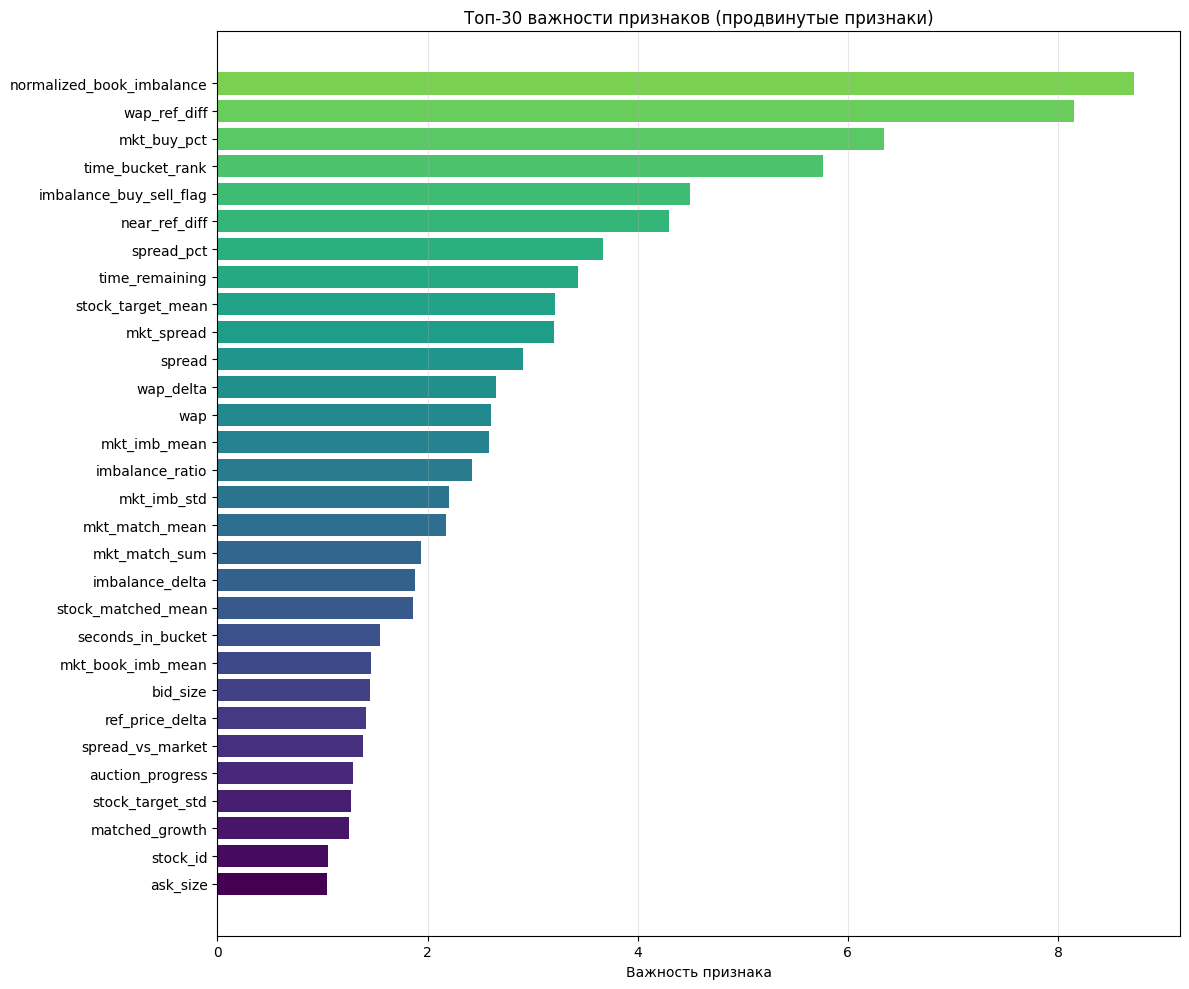

In [15]:
# Визуализация важности признаков
fig, ax = plt.subplots(figsize=(12, 10))

top_n = 30
top_features = importance_df.head(top_n)

colors = plt.cm.viridis(np.linspace(0, 0.8, top_n))
ax.barh(top_features['feature'], top_features['importance'], color=colors[::-1])
ax.set_xlabel('Важность признака')
ax.set_title(f'Топ-{top_n} важности признаков (продвинутые признаки)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [16]:
# Анализ важности новых признаков
new_temporal_features = ['imbalance_size_lag1', 'imbalance_size_lag2', 'matched_size_lag1',
                         'bid_size_lag1', 'ask_size_lag1', 'wap_lag1', 'reference_price_lag1',
                         'imbalance_delta', 'matched_delta', 'matched_growth',
                         'bid_size_delta', 'ask_size_delta', 'wap_delta', 'ref_price_delta',
                         'book_imbalance_lag1', 'book_imbalance_delta',
                         'imbalance_roll_mean3', 'imbalance_roll_std3', 'matched_cummax',
                         'time_remaining', 'auction_progress', 'is_late_auction', 
                         'is_early_auction', 'time_bucket_rank']

new_market_features = ['mkt_imb_mean', 'mkt_imb_std', 'mkt_match_mean', 'mkt_match_sum',
                       'mkt_spread', 'mkt_buy_pct', 'mkt_book_imb_mean', 'mkt_book_imb_std',
                       'imb_vs_market', 'spread_vs_market', 'book_imb_vs_market',
                       'matched_vs_market', 'imb_zscore', 'book_imb_zscore']

new_stock_features = ['stock_target_std', 'stock_target_mean', 'stock_matched_mean',
                      'stock_imb_mean', 'vol_group_encoded', 'liquidity_group_encoded']

print('\n=== Важность новых признаков по категориям ===')

for name, features in [('Временные', new_temporal_features), 
                       ('Рыночные', new_market_features),
                       ('Кластеризация акций', new_stock_features)]:
    subset = importance_df[importance_df['feature'].isin(features)]
    total_imp = subset['importance'].sum()
    print(f'\n{name} признаки (суммарная важность: {total_imp:.2f}):')
    print(subset.head(5).to_string(index=False))


=== Важность новых признаков по категориям ===

Временные признаки (суммарная важность: 21.64):
         feature  importance
time_bucket_rank    5.759501
  time_remaining    3.435739
       wap_delta    2.648896
 imbalance_delta    1.877367
 ref_price_delta    1.413820

Рыночные признаки (суммарная важность: 24.47):
       feature  importance
   mkt_buy_pct    6.347189
    mkt_spread    3.202401
  mkt_imb_mean    2.586104
   mkt_imb_std    2.202430
mkt_match_mean    2.180274

Кластеризация акций признаки (суммарная важность: 7.07):
                feature  importance
      stock_target_mean    3.211699
     stock_matched_mean    1.862538
       stock_target_std    1.268098
         stock_imb_mean    0.536390
liquidity_group_encoded    0.149368


## 6. Итоги

In [17]:
print('=' * 70)
print('ИТОГИ: Результаты продвинутой разработки признаков')
print('=' * 70)
print(f'\nБазовый MAE (manual_ml.ipynb):       5.955036')
print(f'MAE с продвинутыми признаками:       {val_mae:.6f}')
print(f'Абсолютное улучшение:                {5.955036 - val_mae:.6f}')
print(f'Относительное улучшение:             {(5.955036 - val_mae) / 5.955036 * 100:.2f}%')
print(f'\nВсего использовано признаков: {len(feature_cols)}')
print(f'  - Базовые признаки: ~15')
print(f'  - Временные признаки: {len(new_temporal_features)}')
print(f'  - Рыночные признаки: {len(new_market_features)}')
print(f'  - Признаки кластеризации акций: {len(new_stock_features)}')
print('=' * 70)

ИТОГИ: Результаты продвинутой разработки признаков

Базовый MAE (manual_ml.ipynb):       5.955036
MAE с продвинутыми признаками:       5.948068
Абсолютное улучшение:                0.006968
Относительное улучшение:             0.12%

Всего использовано признаков: 68
  - Базовые признаки: ~15
  - Временные признаки: 24
  - Рыночные признаки: 14
  - Признаки кластеризации акций: 6
